In [13]:
from sympy import *
import numpy as np
 
from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)

(None, None)

Define adjacency

Lambda is 
 [[0 0 0]
 [1 0 0]
 [0 1 0]]


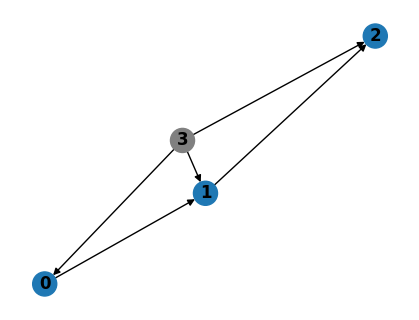

In [14]:
Lambda = get_Lambda([(1,0), (2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1], [1], [1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

Find path matrix

In [15]:
np.set_printoptions(precision=2)
np.random.seed(2021)
noise_distribution = 'gamma'
n = 1000000
p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]

X, true_B = simulate_data(n, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
print(f"true_B is \n {true_B}")
relvlingam = ReLVLiNGAM(X, highest_l)
relvlingam.fit(X) 
B_hat = relvlingam.B
all_possible_permutations = relvlingam.get_all_possible_permutations()
all_Bs = [B_hat[:,perm] for perm in all_possible_permutations]
all_Bs

true_B is 
 [[ 1.    0.    0.    1.  ]
 [ 0.54  1.    0.   -0.21]
 [-0.39 -0.72  1.    1.04]]


[array([[ 1.  ,  0.  ,  0.  ,  1.  ,  0.  ],
        [-0.2 ,  1.  ,  0.  ,  0.55,  1.  ],
        [-0.4 , -3.23,  1.  ,  1.01,  0.06]]),
 array([[ 1.  ,  0.  ,  0.  ,  1.  ,  0.  ],
        [ 0.55,  1.  ,  0.  , -0.2 ,  1.  ],
        [ 1.01, -3.23,  1.  , -0.4 ,  0.06]]),
 array([[ 1.  ,  0.  ,  0.  ,  1.  ,  0.  ],
        [-0.2 ,  1.  ,  0.  ,  0.55,  1.  ],
        [-0.4 ,  0.06,  1.  ,  1.01, -3.23]]),
 array([[ 1.  ,  0.  ,  0.  ,  1.  ,  0.  ],
        [ 0.55,  1.  ,  0.  , -0.2 ,  1.  ],
        [ 1.01,  0.06,  1.  , -0.4 , -3.23]])]

In [16]:
X

array([[ 0.02, -0.05,  0.05],
       [-0.01,  0.04, -0.11],
       [-0.07,  0.  , -0.24],
       ...,
       [-0.28,  0.04, -0.25],
       [ 0.4 , -0.23,  0.57],
       [-0.23, -0.15, -0.04]])

Equations for b_21 or b_31

In [17]:
from direct_lingam.constraints_to_test import get_constraints_for_l_latents
equations_bij = get_constraints_for_l_latents(1)['equations_bij']
for eq in equations_bij:
    display(eq)

eq = equations_bij[0]
i, j = 1, 0
specify_nodes = {sym: symbols(sym.name[:2] + "".join(sorted(sym.name[2:].replace("j", str(j)).replace("i", str(i))))) for sym in reduce(set.union, [eq.free_symbols for eq in equations_bij]) if str(sym) != "b_ij"}
cumulants = relvlingam._estimate_cumulants(X)
symbols_to_cumulants = relvlingam._form_symbol_to_cumulant_dict(cumulants, [i, j], scale_partly=False) # Scaling would be used for finding the source, for effect estimation we must not scale
estimated_coeffs = [float(coeff.subs(specify_nodes).subs(symbols_to_cumulants)) for coeff in eq.all_coeffs()]
# A numpy polynomial has the opposite order of coefficients to sympy: Numpy starts with the lowest power, 
# Sympy with the highest. Therefore, reverse the coefficients.
poly_10 = np.polynomial.Polynomial(estimated_coeffs[::-1])
print(poly_10)
roots_10 = poly_10.roots()
roots_10

Poly((-c_ijj*c_jjjj + c_ijjj*c_jjj)*b_ij**2 + (c_iij*c_jjjj - c_iijj*c_jjj)*b_ij - c_iij*c_ijjj + c_iijj*c_ijj, b_ij, domain='ZZ[c_iij,c_iijj,c_ijj,c_ijjj,c_jjj,c_jjjj]')

Poly((c_iijj*c_jjj - c_ijj*c_ijjj)*b_ij**2 + (-c_iiij*c_jjj + c_iij*c_ijjj)*b_ij + c_iiij*c_ijj - c_iij*c_iijj, b_ij, domain='ZZ[c_iiij,c_iij,c_iijj,c_ijj,c_ijjj,c_jjj]')

Poly((c_iijj*c_jjjj - c_ijjj**2)*b_ij**2 + (-c_iiij*c_jjjj + c_iijj*c_ijjj)*b_ij + c_iiij*c_ijjj - c_iijj**2, b_ij, domain='ZZ[c_iiij,c_iijj,c_ijjj,c_jjjj]')

-5.31e-06 - (1.99e-05)·x + (5.37e-05)·x²


array([-0.18,  0.55])

In [18]:
from direct_lingam.constraints_to_test import get_constraints_for_l_latents
equations_bij = get_constraints_for_l_latents(1)['equations_bij']
for eq in equations_bij:
    display(eq)

eq = equations_bij[0]
i, j = 2, 0
specify_nodes = {sym: symbols(sym.name[:2] + "".join(sorted(sym.name[2:].replace("j", str(j)).replace("i", str(i))))) for sym in reduce(set.union, [eq.free_symbols for eq in equations_bij]) if str(sym) != "b_ij"}
cumulants = relvlingam._estimate_cumulants(X)
symbols_to_cumulants = relvlingam._form_symbol_to_cumulant_dict(cumulants, [i, j], scale_partly=False) # Scaling would be used for finding the source, for effect estimation we must not scale
estimated_coeffs = [float(coeff.subs(specify_nodes).subs(symbols_to_cumulants)) for coeff in eq.all_coeffs()]
# A numpy polynomial has the opposite order of coefficients to sympy: Numpy starts with the lowest power, 
# Sympy with the highest. Therefore, reverse the coefficients.
poly_20 = np.polynomial.Polynomial(estimated_coeffs[::-1])
print(poly_20)
roots_20 = poly_20.roots()
roots_20

Poly((-c_ijj*c_jjjj + c_ijjj*c_jjj)*b_ij**2 + (c_iij*c_jjjj - c_iijj*c_jjj)*b_ij - c_iij*c_ijjj + c_iijj*c_ijj, b_ij, domain='ZZ[c_iij,c_iijj,c_ijj,c_ijjj,c_jjj,c_jjjj]')

Poly((c_iijj*c_jjj - c_ijj*c_ijjj)*b_ij**2 + (-c_iiij*c_jjj + c_iij*c_ijjj)*b_ij + c_iiij*c_ijj - c_iij*c_iijj, b_ij, domain='ZZ[c_iiij,c_iij,c_iijj,c_ijj,c_ijjj,c_jjj]')

Poly((c_iijj*c_jjjj - c_ijjj**2)*b_ij**2 + (-c_iiij*c_jjjj + c_iijj*c_ijjj)*b_ij + c_iiij*c_ijjj - c_iijj**2, b_ij, domain='ZZ[c_iiij,c_iijj,c_ijjj,c_jjjj]')

4.13e-05 + (5.84e-05)·x - (1.02e-04)·x²


array([-0.41,  0.98])

Estimate cumulants

In [19]:
j, i = 0, 1
source, other_node = j, i
l = 1 # The number of latent variables confounding 1 and 2
highest_order = 4 # Order up to which to estimate cumulants
marginal_omegas_10 = np.full((l+1, highest_order-1), np.nan)
# For k < l+1, the marginal omega cannot be infered.
for k in range(l+1, highest_order+1):
    B_tilde = [roots_10**i for i in range(k)]
    symbols_to_cumulants = relvlingam._form_symbol_to_cumulant_dict(cumulants, [i, j], scale_partly=False)
    y = np.array([float(symbols_to_cumulants[symbols(f"c_{''.join(sorted((str(source),)*(k - i) + (str(other_node),)*i))}")]) for i in range(k)])
    try:
        marginal_omegas_10[:,k-2] = np.linalg.lstsq(B_tilde, y, rcond=None)[0]
    except np.linalg.LinAlgError:
        raise MathError(f"Linear system for {k}th order omega for source {source} and test node {other_node} is singular.")
    
marginal_omegas_10 # Each column corresponfs to one order, each row to one exogeneous source, i.e. epsilon_1, L_1, ..., L_l

array([[0.03, 0.01, 0.01],
       [0.06, 0.04, 0.04]])

In [20]:
j, i = 0, 2
source, other_node = j, i
l = 1 # The number of latent variables confounding 1 and 2
highest_order = 4 # Order up to which to estimate cumulants
marginal_omegas_20 = np.full((l+1, highest_order-1), np.nan)
# For k < l+1, the marginal omega cannot be infered.
for k in range(l+1, highest_order+1):
    B_tilde = [roots_20**i for i in range(k)]
    symbols_to_cumulants = relvlingam._form_symbol_to_cumulant_dict(cumulants, [i, j], scale_partly=False)
    y = np.array([float(symbols_to_cumulants[symbols(f"c_{''.join(sorted((str(source),)*(k - i) + (str(other_node),)*i))}")]) for i in range(k)])
    try:
        marginal_omegas_20[:,k-2] = np.linalg.lstsq(B_tilde, y, rcond=None)[0]
    except np.linalg.LinAlgError:
        raise MathError(f"Linear system for {k}th order omega for source {source} and test node {other_node} is singular.")
    
marginal_omegas_20 # Each column corresponfs to one order, each row to one exogeneous source, i.e. epsilon_1, L_1, ..., L_l

array([[0.06, 0.04, 0.04],
       [0.03, 0.01, 0.01]])

In [21]:
def match_marginals(marginal_omegas_10, marginal_omegas_20):
    if marginal_omegas_10.shape[0] != marginal_omegas_20.shape[0]:
        raise ValueError("The number of rows of the marginal omegas must be the same.")
    if marginal_omegas_10.shape[1] != marginal_omegas_20.shape[1]:
        raise ValueError("The number of columns of the marginal omegas must be the same.")
    l = marginal_omegas_10.shape[0]-1
    match_1, match_2 = [[0, 0], [1, 1]],  [[0, 1], [1, 0]]
    dist_1 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20)))
    dist_2 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20[[1, 0]])))
    print(f"dist_1 is {dist_1}")
    print(f"dist_2 is {dist_2}")
    if dist_1 < dist_2:
        return match_1
    else:
        return match_2

In [22]:
match = match_marginals(marginal_omegas_10, marginal_omegas_20)
root_pairs = [[roots_10[match[0][0]], roots_20[match[0][1]]], [roots_10[match[1][0]], roots_20[match[1][1]]]]
print(root_pairs[0])
print(root_pairs[1])

dist_1 is 0.18755939800043736
dist_2 is 0.000570773341094467
[-0.17979859351371413, 0.9829736432557381]
[0.55029552036536, -0.4114093405988498]


In [43]:
cov_matrix = cumulants.get(2)